# <center> Facial Emotions
#  <center> classification: Inception
# <center> ResNet Approaches

### In this notbokk we mainlly Compaire bbetween two approaches the First one is an integration between 

### Inception ResNet V2 and U-NET and the second one is using only Inception ResNet V2 

## Explaining the First Approache :  
    
    Combining the Inception ResNet2 architecture with the U-Net framework creates a powerful synergy between two distinct strengths in deep learning. Inception ResNet2 excels at extracting intricate and multi-scale features from images, thanks to its sophisticated inception modules and residual connections. On the other hand, U-Net is renowned for its prowess in precise image segmentation, particularly in tasks where spatial information is crucial, such as facial emotion recognition. 
    
    This integration enables the model to not only capture high-level abstract features indicative of facial emotions but also localize these emotions precisely within the image.


    this integration fosters a holistic understanding of facial emotion recognition by leveraging both global and local information. Inception ResNet2’s global context awareness ensures that the model comprehends the broader context of facial expressions, while U-Net’s local focus allows for finegrained analysis of emotional nuances within different facial region

#### Used Libraries !

In [21]:
import tensorflow
from keras.layers import Conv2DTranspose, Input, ZeroPadding2D, Cropping2D
from keras.models import Model
from keras.applications import InceptionResNetV2
import matplotlib.pyplot as plt 
from keras.regularizers import l2 
import time
import os
import cv2
import numpy as np
import random #
from tensorflow.keras import layers, callbacks
from deap import base, creator, tools, algorithms
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.layers import  Add
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
import seaborn as sns
from keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from keras.layers import Dropout, Flatten, Dense
import cv2 as cv
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf

In [22]:
import os
import cv2


# base_path = r'/kaggle/input/fer2013/train'
base_path =r'/kaggle/input/autistic-children-emotions-dr-fatma-m-talaat/Autistic Children Emotions - Dr. Fatma M. Talaat/Train'

# Initialize dictionaries 
folder_image_names = {}
image_data = {}

# list of all directories in the base path
directories = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

#  number of images  from each folder
num_images_per_folder = 100

# Loop on each directory
for directory in directories:
    dir_path = os.path.join(base_path, directory)
    
    # we access to all the images in that directoryyy
    image_files = [f for f in os.listdir(dir_path) if f.endswith('.jpg') ]
    
    # If there are less than 100 images in the directory, read all of them
#     num_images = min(num_images_per_folder, len(image_files))
    
    # Store image names for each folder 
    folder_image_names[directory] = image_files[:num_images_per_folder] # {'Folder name ':the images names}
    
    # Loop on each image in a directory
    for image_file in image_files[:num_images_per_folder]:
        image_path = os.path.join(dir_path, image_file) # the path to the current image
        
        image = cv2.imread(image_path)
        
        image_data[image_file] = image # {'image name' : image data array }

In [23]:
print(directories)

['joy', 'surprise', 'fear', 'sadness', 'Natural', 'anger']


In [24]:
print(folder_image_names.keys()) # All the labels we do have 
# print(folder_image_names) # All the labels we do have 

dict_keys(['joy', 'surprise', 'fear', 'sadness', 'Natural', 'anger'])


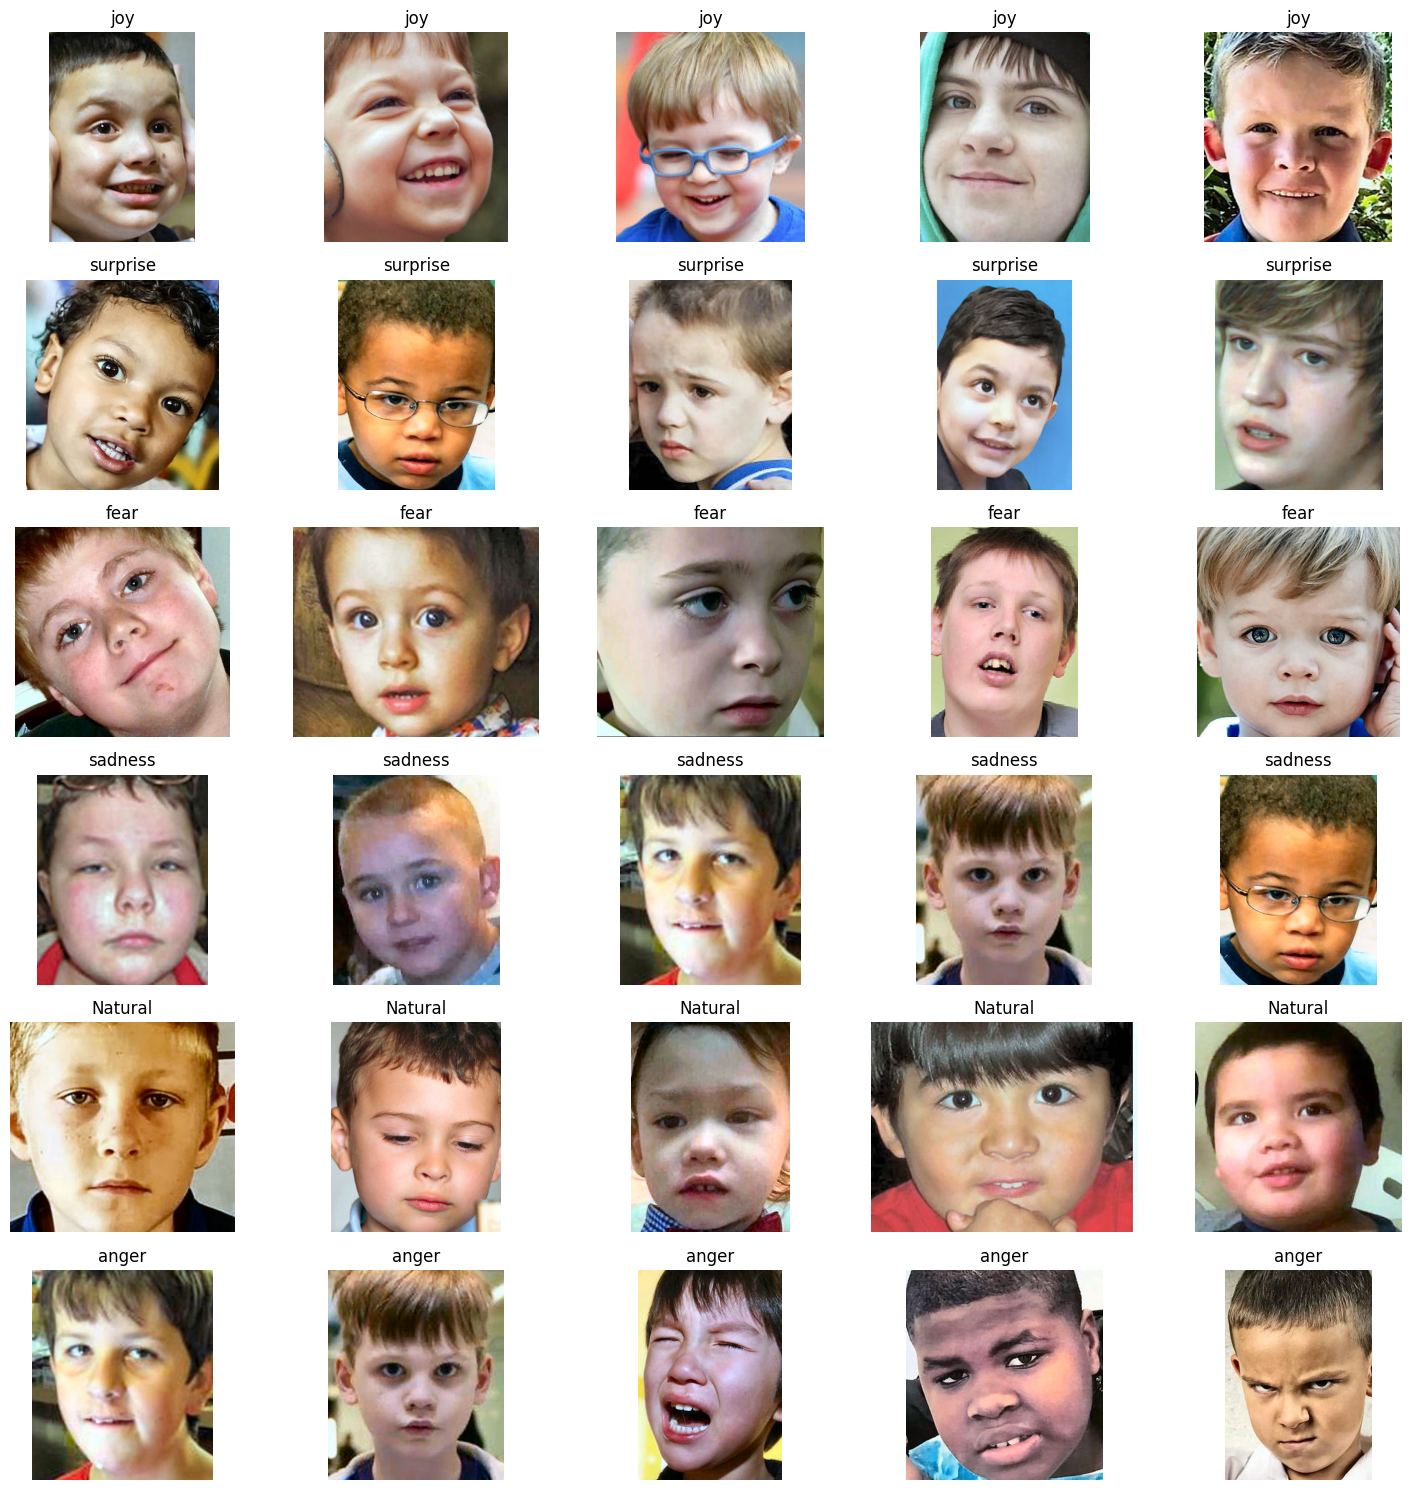

In [28]:
# Define the number of images to plot from each folder
num_images_to_plot = 5

# Calculate the number of rows needed based on the number of directories
num_rows = len(directories)

fig, axs = plt.subplots(num_rows, num_images_to_plot, figsize=(15, 15))

for i, directory in enumerate(directories):
    dir_path = os.path.join(base_path, directory)
    
    image_files = [f for f in os.listdir(dir_path) if f.endswith('.jpg') ]
    
    # If there are less than 5 images in the directory, plot all of them
#     num_images = min(num_images_to_plot, len(image_files))
    
    # Plot the folder name above each row
    axs[i, 0].set_title(directory, fontsize=22)
    
    # Loop through each image in the directory
    for j in range(num_images_to_plot):
        image_path = os.path.join(dir_path, image_files[j])
        
        image = cv2.imread(image_path)
        
        axs[i, j].set_title(directory, fontsize=12)
        
        # Plot the image
        axs[i, j].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) ; axs[i, j].axis('off')

plt.tight_layout()
plt.show()

# Dataset: Autistic Children Emotions

The dataset used in this project is the **Autistic Children Emotions** dataset, 
created by **Dr. Fatma M. Talaat**. It is specifically designed for facial emotion 
recognition in autistic children — a challenging and underexplored area in 
affective computing research.

## Dataset Details

| Property | Value |
|---|---|
| Total Classes | 6 |
| Image Format | JPG |
| Input Size (used) | 299 × 299 px |
| Source | Kaggle |

## Emotion Classes

| Label | Emotion |
|---|---|
| 0 | Joy |
| 1 | Sadness |
| 2 | Fear |
| 3 | Anger |
| 4 | Surprise |
| 5 | Natural |

## Train / Test Split

| Split | Images |
|---|---|
| Train | structured in class folders |
| Test | structured in class folders |

> ⚠️ **Note**: The dataset is **imbalanced** — Joy is the dominant class with 
significantly more samples than Anger, Fear, and Surprise. This directly 
impacts model performance on minority classes.

🔗 [Dataset on Kaggle](https://www.kaggle.com/datasets/your-link-here)

# Digging Depper into Inception ResNet V2 architecture

**The Inception module,composed of a series of residual blocks with skip connections, forms the backboneof Inception-ResNet v2. This configuration, illustrated in the network diagram below, visually represents the intricate relationship between Inception and ResNet components.** 

**By incorporating residual connections within the Inception blocks, Inception-ResNet v2 ensures that the gradients are directlypropagated to subsequent layers. This strategic approach mitigates the vanishing gradient problem, depicted in the figure, by consistently adding the gradient results to the next layers during training.**


    The integration of residual connections within the Inception architecture addresses the vanishing gradient issue more comprehensively. Unlike traditional architectures where gradients tend to diminish as they propagate deeper into the network, Inception-ResNet v2 maintains a robust gradient flow, as depicted in the visual representation

# Digging Depper Into U-Net architecture 

**U-Net is a convolutional neural network (CNN) architecture widely used for image segmentation tasks, particularly in medical image analysis. It comprises encoder and decoder parts, each serving distinct purposes in the segmentation process.**

#### Encoder Part : 
The encoder is responsible for feature extraction from input images and consists of a series of convolutions with 3x3 kernels, followed by Rectified Linear Unit (ReLU) activation functions. Additionally, 2x2 max-pooling layers are employed between stages to downsample the image shapes, aiding in feature abstraction while preserving spatial information.

#### The decoder Part:
the decoder portion of U-Net comprises a series of 3x3 convolutional layers, also followed by ReLU activations. However, instead of downsampling, upsampling operations are performed to restore the original image shapes. The upsampling process allows for the reconstruction of high-resolution feature maps from the abstract representations generated by the encoder.

    The connection between the encoder and decoder is a pivotal aspect of U8 Net’s architecture. It facilitates the integration of high-level semantic information from the encoder with the spatial details preserved in the decoder. 
    
####  Two types of connections are commonly used to connect the Encoder with the Decoder: 


- the skip connections, which involve copying and concatenating symmetrical parts of the encoder to the decoder, 
- and the bottleneck, where the transition occurs between the encoder and decoder parts. 
This bottleneck serves as a bridge, facilitating the flow of information from the encoder to the decoder while maintaining contextual information crucial for accurate segmentation

# Intergrating the Inception Resnet Into U-net architecture : 

**In the proposed model, the feature extraction process with Inception ResNet2 serves as a crucial backbone for facial emotion recognition. A backbone, in essence, forms the foundational architecture upon which subsequent layers operate, providing essential features for downstream tasks. As facial images are inputted into the encoder, Inception ResNet2 excels in extracting rich, multi-scale features that encapsulate the complexity of human expressions**  

     Through its deep convolutional layers and innovative inception modules, Inception ResNet2 demonstrates a remarkable ability to discern subtle patterns and nuances within facial features, capturing the intricate details associated with various emotional states. This feature extraction stage lays the groundwork for the subsequent stages of the model, providing a comprehensive representation of facial expres sions essential for accurate classification.  
     
     
**In the final classification stage, the model refines its understanding of facial emotion expressions through a series of carefully designed layers. Global average pooling is employed to consolidate the refined features obtained from the segmentation masks, allowing the model to focus on the most pertinent information across spatial dimensions. This pooling operation ensures that the model captures the essence of emotional expressions while minimizing the impact of irrelevant details**

# Inception Resnet v2 And U-Net

In [3]:
# from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, ZeroPadding2D
# from tensorflow.keras.models import Model
# from tensorflow.keras.applications import InceptionResNetV2

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_inception_resnetv2_unet(drop,input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained InceptionResNetV2 Model """
    encoder = InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=inputs)
    encoder.trainable = True

    for layer in encoder.layers[:-20]:
        layer.trainable = False
#     encoder.summary()

    for i, layer in enumerate(encoder.layers):
        if i==0 : a1 = layer.name ; #print(i, layer.name)
        if i == 3 : a2 = layer.name ; # print(i, layer.name)
        elif i== 13 : b11 = layer.name ; #print(i, layer.name)
        elif i== 266 : c1 = layer.name ; #print(i, layer.name)
        elif i == 606 : d11 = layer.name ; #print(i, layer.name)
#         print(i, layer.name) 

    s1 = encoder.get_layer(a1).output                       ## (512 x 512)
    s2 = encoder.get_layer(a2).output                       ## (255 x 255)                    # 3
    s2 = layers.ZeroPadding2D(((1, 0), (1, 0)))(s2)         ## (256 x 256)
    s3 = encoder.get_layer(b11).output                      ## (126 x 126)                    # 13
    s3 = layers.ZeroPadding2D((1, 1))(s3)                   ## (128 x 128)
    s4 = encoder.get_layer(c1).output                       ## (61 x 61)                      # 266 
    s4 = layers.ZeroPadding2D(((2, 1), (2, 1)))(s4)         ## (64 x 64)

    # Bridge
    b1 = encoder.get_layer(d11).output                      ## (30 x 30)                       # 606 
    b1 = layers.ZeroPadding2D((1, 1))(b1)                   ## (32 x 32)

    # Decoder layer
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)
    
    """ Output """
    
    num_classes = 7
    gap = layers.GlobalAveragePooling2D()(d4)
    dropout = layers.Dropout(0.2)(gap)
    outputs = layers.Dense(num_classes, activation="sigmoid")(dropout)

    # Build the model

    model = Model(inputs, outputs, name="InceptionResNetV2_U-Net")
    return model


if __name__ == "__main__":
    input_shape = (128, 128, 3)
    model = build_inception_resnetv2_unet(0.02,input_shape)


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
# labels[0]

In [29]:
def read_images_from_directories(root_dir,x):
    images = []
    labels = []

    # Get the list of subdirectories (labels)
    subdirectories = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

    # Iterate through each subdirectory (label)
    for label_idx, label in enumerate(subdirectories):
        label_dir = os.path.join(root_dir, label)

        # Get the list of image filenames in the label directory
        image_filenames = [f for f in os.listdir(label_dir) if f.endswith('.jpg') or f.endswith('.png')]

        # Shuffle the list of image filenames
        random.shuffle(image_filenames)

        # Load images and labels
        num_images_to_read = min(x, len(image_filenames))  # Read up to 40 images
        for image_filename in image_filenames[:num_images_to_read]:
            image_path = os.path.join(label_dir, image_filename)
            image = cv2.imread(image_path)  # Read image
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
            images.append(image)
            labels.append(label)

    return images, labels

In [72]:
# Example usage:
root_directory = '/kaggle/input/autistic-children-emotions-dr-fatma-m-talaat/Autistic Children Emotions - Dr. Fatma M. Talaat/Train'
images, labels = read_images_from_directories(root_directory,100)

## Reshaping the images to 128*128  in Order to fit the input layer !

In [73]:
resized_images = []

for image in images:
    resized_image = cv2.resize(image, (128, 128))
    resized_images.append(resized_image)

# Convert the list of resized images to a numpy array
resized_images = np.array(resized_images)

# Verify the shape of resized images
print("Resized Images Shape:", resized_images.shape)
# Shuffle the images and labels in unison
shuffled_images, shuffled_labels = shuffle(resized_images, labels, random_state=42)
resized_images = shuffled_images.astype('float32') / 255.0

Resized Images Shape: (408, 128, 128, 3)


In [74]:
label_encoder = LabelEncoder()
# Fit and transform the labels to integers
encoded_labels = label_encoder.fit_transform(shuffled_labels)
# Print the unique classes and their corresponding integer labels
print("Classes:", label_encoder.classes_)
print("Encoded Labels:", encoded_labels)
labels = to_categorical(encoded_labels)

Classes: ['Natural' 'anger' 'fear' 'joy' 'sadness' 'surprise']
Encoded Labels: [3 4 4 3 3 3 5 0 4 4 1 3 4 1 5 2 2 4 3 4 3 1 4 4 4 0 3 4 2 3 5 3 3 5 4 4 3
 0 3 0 0 1 5 5 5 0 3 1 2 5 5 3 5 3 1 1 3 3 3 4 3 2 3 5 0 2 1 5 3 4 4 0 3 2
 5 3 3 3 1 1 1 1 0 3 3 5 5 1 3 4 4 1 3 4 5 1 4 2 4 1 4 4 3 5 5 3 3 4 3 3 2
 1 1 0 1 0 1 0 3 3 4 4 0 5 5 3 4 3 0 5 0 5 2 4 4 5 4 4 4 5 1 3 5 0 0 4 4 3
 5 1 2 3 1 0 5 3 4 5 3 4 4 1 4 4 0 2 3 4 2 5 4 3 3 5 3 5 1 3 1 3 3 3 5 5 4
 2 3 1 4 4 0 1 5 5 4 3 1 0 1 4 1 1 2 1 1 4 4 5 3 3 4 2 4 5 2 0 1 1 5 1 4 1
 0 1 1 2 1 5 5 4 4 1 3 4 4 5 4 4 3 5 0 4 4 4 0 1 4 5 3 1 3 3 0 5 4 0 5 0 3
 1 3 3 4 2 5 3 3 3 2 5 0 1 4 3 3 4 0 0 2 3 0 4 4 4 0 3 4 1 5 4 1 4 2 3 4 4
 3 3 3 4 4 1 3 0 4 4 4 5 1 5 3 5 5 3 3 0 3 5 3 1 0 4 4 1 4 4 4 0 1 4 1 1 0
 4 4 5 3 4 2 0 4 5 3 3 3 3 4 3 4 3 0 3 1 4 4 3 0 3 4 2 0 1 5 0 1 0 4 3 1 3
 2 2 1 2 2 3 3 1 4 4 3 0 5 4 2 1 0 1 4 0 5 5 5 1 3 1 3 0 4 5 1 3 2 3 5 4 1
 5]


#### Compliling the Model 
- Using `adam` as optimatoz 
- Categorical Cross Entropy as loss Fuction 
- Accuracy as a Metrics of evauation 

In [12]:
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

### Fitting the model with the data !

In [13]:
# history =  model.fit(resized_images, labels ,batch_size=16 , epochs=20, validation_split=0.1, callbacks=[early_stopping])
#                     callbacks=[callback(patience=15)] )
history = model.fit(resized_images, labels,
#                     validation_data=datagen.flow(resized_images, labels, batch_size=16, subset='validation'),
                    validation_split=0.2, 
                    epochs=30)# , callbacks=[early_stopping])

Epoch 1/30


I0000 00:00:1715802820.763259     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 ━━━━━━━━━━━━━━━━━━━━ 122s 7s/step - accuracy: 0.1582 - loss: 2.1102 - val_accuracy: 0.1571 - val_loss: 18.5323
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.1970 - loss: 1.8807 - val_accuracy: 0.1571 - val_loss: 33.2216
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.2637 - loss: 1.8152 - val_accuracy: 0.0857 - val_loss: 41.0969
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.2857 - loss: 1.7670 - val_accuracy: 0.2143 - val_loss: 8.6271
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.3525 - loss: 1.5805 - val_accuracy: 0.0857 - val_loss: 28.3381
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.3289 - loss: 1.5887 - val_accuracy: 0.2000 - val_loss: 7.2952
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.5256 - loss: 1.3539 - val_accuracy: 0.1857 - val_loss: 12.5460
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.4642 - loss: 1.3484 - val_accuracy: 0.2714 - val_loss: 3.6655

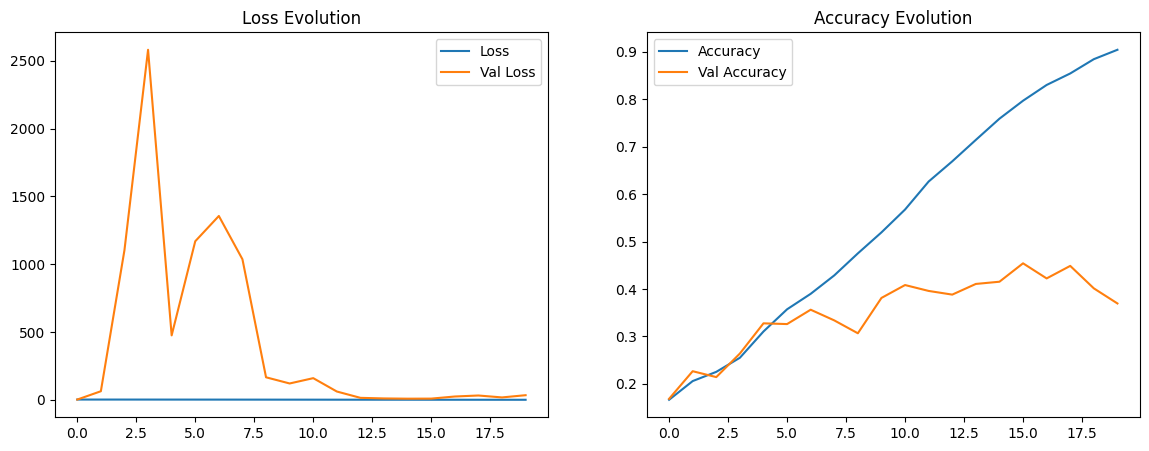

In [18]:
# Tracer les courbes de loss et de précision
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Evolution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Evolution')
plt.legend()
plt.show()

In [22]:
## Test data 
root_directory = '/kaggle/input/autistic-children-emotions-dr-fatma-m-talaat/Autistic Children Emotions - Dr. Fatma M. Talaat/Test'
images_Test, labels_test = read_images_from_directories(root_directory)

In [23]:
resized_images_test = []

for image in images_Test:
    resized_image = cv2.resize(image, (128, 128))
    resized_images_test.append(resized_image)

# Convert the list of resized images to a numpy array
resized_images_test = np.array(resized_images_test)

# Verify the shape of resized images
print("Resized Images Shape:", resized_images_test.shape)

Resized Images Shape: (75, 128, 128, 3)


### Encoding the images Labels ! 'Test Images' 

In [24]:
# augmented_labels[2]
from sklearn.preprocessing import LabelEncoder
# Initialize the LabelEncoder
label_encoder = LabelEncoder()
# Fit and transform the labels to integers
encoded_labels_test = label_encoder.fit_transform(labels_test)
# Print the unique classes and their corresponding integer labels
print("Classes:", label_encoder.classes_)
print("Encoded Labels:", encoded_labels_test)

Classes: ['Natural' 'anger' 'fear' 'joy' 'sadness' 'surprise']
Encoded Labels: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 5 5 5 5 5 5 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 1 1
 1]


In [25]:
labels_test = to_categorical(encoded_labels_test)

In [26]:
# test accuracy Evaluation : 
test_loss, test_accuracy = model.evaluate(resized_images_test, labels_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3547 - loss: 2.8440 
Test Loss: 2.5835561752319336
Test Accuracy: 0.3857142925262451


# Using only Enception ResNet 

## Enception ResNet V2 :  

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    '/kaggle/input/autistic-children-emotions-dr-fatma-m-talaat/Autistic Children Emotions - Dr. Fatma M. Talaat/Train',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    subset='training')

validation_generator = datagen.flow_from_directory(
    '/kaggle/input/autistic-children-emotions-dr-fatma-m-talaat/Autistic Children Emotions - Dr. Fatma M. Talaat/Test',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    subset='validation')


Found 608 images belonging to 6 classes.
Found 12 images belonging to 6 classes.


In [4]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [5]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


## Below we've fixed an very important  parameter : wich is the layers we are willing to train 
- So for the First 500 layers we tend to fixe the innitial wieghts given in the pre-Trainet ResNet 
- the we've choosed to only change the other layers wieghts 


        by other mean we changed only the layers we juged responsible for the Classification  !

In [6]:
# for layer in base_model.layers:
#     layer.trainable = False
for layer in base_model.layers[:500]:
    layer.trainable = False
for layer in base_model.layers[500:]:
    layer.trainable = True

### Compiling the model with : 
- `Adam` as optimiser 
- Categorical Cross Entropy as  Loss function 
- Accuracy as metrics evaluation 

In [7]:
    
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=25,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size)


Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1715813825.814872     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.4277 - loss: 1.5331 - val_accuracy: 0.6667 - val_loss: 1.7385
Epoch 2/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6667 - val_loss: 1.7385
Epoch 3/25


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 270ms/step - accuracy: 0.6863 - loss: 0.8730 - val_accuracy: 0.6667 - val_loss: 2.0247
Epoch 4/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6667 - val_loss: 2.0247
Epoch 5/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 271ms/step - accuracy: 0.7233 - loss: 0.6076 - val_accuracy: 0.6667 - val_loss: 1.3535
Epoch 6/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6667 - val_loss: 1.3535
Epoch 7/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - accuracy: 0.8128 - loss: 0.4276 - val_accuracy: 0.6667 - val_loss: 1.5659
Epoch 8/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6667 - val_loss: 1.5659
Epoch 9/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - accuracy: 0.8865 - loss: 0.2938 - val_accuracy: 0.6667 - val_loss: 1.2341
Epoch 10/25
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - va

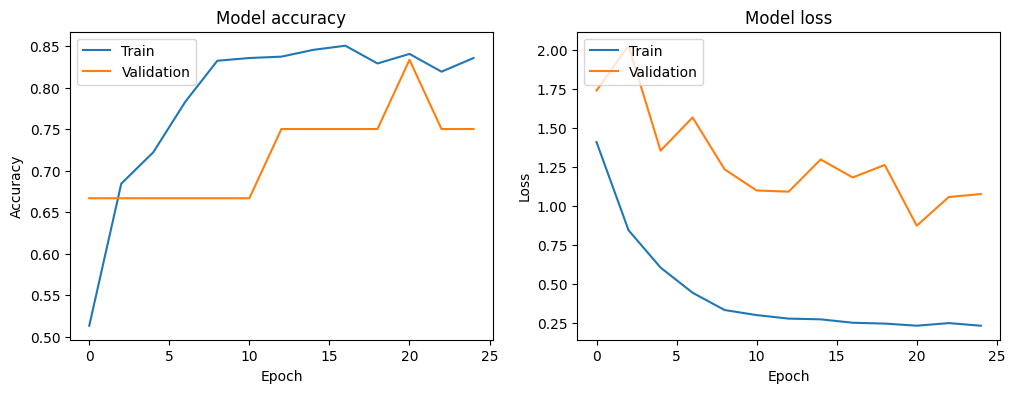

In [8]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Filter out epochs where accuracy is 0.0
filtered_accuracy = [acc for acc in accuracy if acc != 0.0]
filtered_val_accuracy = [val_acc for i, val_acc in enumerate(val_accuracy) if accuracy[i] != 0.0]
filtered_loss = [l for i, l in enumerate(loss) if accuracy[i] != 0.0]
filtered_val_loss = [val_l for i, val_l in enumerate(val_loss) if accuracy[i] != 0.0]

# Get the corresponding epochs
filtered_epochs = [i for i, acc in enumerate(accuracy) if acc != 0.0]

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(filtered_epochs, filtered_accuracy, label='Train')
plt.plot(filtered_epochs, filtered_val_accuracy, label='Validation')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(filtered_epochs, filtered_loss, label='Train')
plt.plot(filtered_epochs, filtered_val_loss, label='Validation')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Model compilation and training
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr])

Epoch 1/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 86s 948ms/step - accuracy: 0.8316 - loss: 0.3171 - val_accuracy: 0.4167 - val_loss: 4.6235 - learning_rate: 1.0000e-04
Epoch 2/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4167 - val_loss: 4.6235 - learning_rate: 1.0000e-04
Epoch 3/15


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 288ms/step - accuracy: 0.8245 - loss: 0.3079 - val_accuracy: 0.3333 - val_loss: 2.6327 - learning_rate: 1.0000e-04
Epoch 4/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3333 - val_loss: 2.6327 - learning_rate: 1.0000e-04
Epoch 5/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step - accuracy: 0.8565 - loss: 0.2322 - val_accuracy: 0.6667 - val_loss: 1.5609 - learning_rate: 1.0000e-04
Epoch 6/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6667 - val_loss: 1.5609 - learning_rate: 1.0000e-04
Epoch 7/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 288ms/step - accuracy: 0.8723 - loss: 0.2184 - val_accuracy: 0.7500 - val_loss: 1.2098 - learning_rate: 1.0000e-04
Epoch 8/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 1.2098 - learning_rate: 1.0000e-04
Epoch 9/15
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - ac

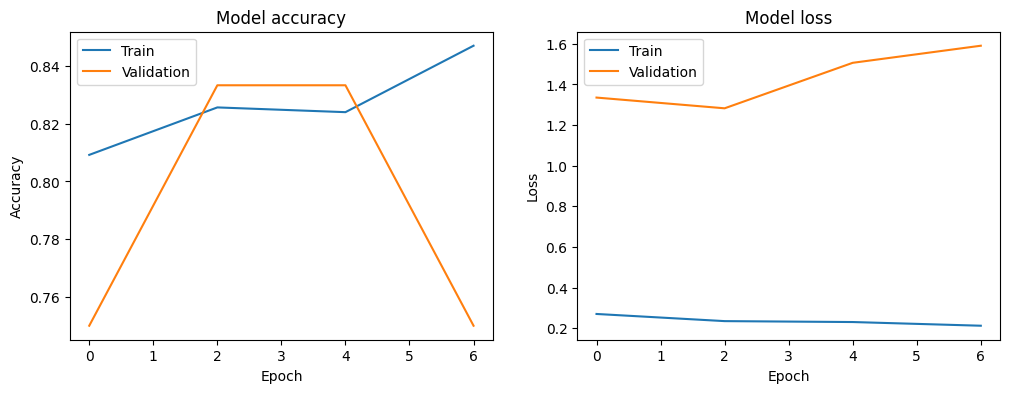

In [17]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

filtered_accuracy = [acc for acc in accuracy if acc != 0.0]
filtered_val_accuracy = [val_acc for i, val_acc in enumerate(val_accuracy) if accuracy[i] != 0.0]
filtered_loss = [l for i, l in enumerate(loss) if accuracy[i] != 0.0]
filtered_val_loss = [val_l for i, val_l in enumerate(val_loss) if accuracy[i] != 0.0]

filtered_epochs = [i for i, acc in enumerate(accuracy) if acc != 0.0]

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(filtered_epochs, filtered_accuracy, label='Train')
plt.plot(filtered_epochs, filtered_val_accuracy, label='Validation')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(filtered_epochs, filtered_loss, label='Train')
plt.plot(filtered_epochs, filtered_val_loss, label='Validation')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Assuming 'test' directory has the test images structured in the same way as train and validation directories
test_generator = datagen.flow_from_directory(
    '/kaggle/input/autistic-children-emotions-dr-fatma-m-talaat/Autistic Children Emotions - Dr. Fatma M. Talaat/Test',
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')



Found 75 images belonging to 6 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.6771 - loss: 1.9110 
Test Loss: 1.945085883140564
Test Accuracy: 0.6666666865348816


In [17]:
# Predict on the test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Generate classification report
# print('Classification Report')
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))




3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
              precision    recall  f1-score   support

     Natural       0.25      0.57      0.35         7
       anger       0.00      0.00      0.00         3
        fear       0.00      0.00      0.00         3
         joy       0.79      0.90      0.84        42
     sadness       0.20      0.07      0.11        14
    surprise       0.33      0.33      0.33         6

    accuracy                           0.60        75
   macro avg       0.26      0.31      0.27        75
weighted avg       0.53      0.60      0.55        75



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Conclusion

In this project, we explored two approaches for facial emotion classification on the **Autistic Children Emotions** dataset across 6 classes: Joy, Sadness, Fear, Anger, Surprise, and Natural.

## Approach Comparison

| Metric | Inception ResNet V2 + U-Net | Inception ResNet V2 Only |
|---|---|---|
| Test Accuracy | — | **66.67%** |
| Joy F1-score | — | 0.84 |
| Macro Avg F1 | — | 0.27 |

> Fill in the first column once you have the results from Approach 1.

## Key Observations

- The model performs **very well on Joy** (F1 = 0.84), which is the dominant class with 42 out of 75 test samples
- It struggles significantly with **Anger and Fear** (F1 = 0.00), which only had 3 test samples each — this is a **class imbalance problem**, not necessarily a model failure
- The **macro average F1 of 0.27** reflects this imbalance heavily

## What Could Be Improved

- **Address class imbalance**: Use oversampling (SMOTE), class weights, or collect more data for underrepresented emotions
- **More training data**: Only 100 images per class were used — increasing this would likely boost performance significantly
- **Fine-tune deeper layers**: Unfreeze some layers of Inception ResNet V2 for task-specific feature learning
- **Stronger augmentation**: Especially for minority classes (Anger, Fear, Surprise)